# Support Vector Machine Classification
Support Vector Machine (SVM) is a powerful machine learning algorithm used for classification problems. It is particularly useful for problems with complex decision boundaries, as it can handle both linear and non-linear relationships between features and the target variable.

In this Jupyter notebook, we will explore how to use SVM for classification problems using PySpark. Specifically, we will use the Breast Cancer Wisconsin dataset, which contains information about the physical and chemical characteristics of breast tumors, to build an SVM model that can predict whether a tumor is benign or malignant. We will cover the following topics:

- Loading and preparing the data
- Training an SVM model using PySpark's MLlib library
- Evaluating the model's performance using various metrics
- Tuning the model's hyperparameters to improve its performance
By the end of this notebook, you should have a good understanding of how SVM works and how to apply it to real-world classification problems using PySpark.

## Introduction

The Breast Cancer Wisconsin dataset is a widely-used benchmark dataset for binary classification problems. It contains information about breast cancer tumors detected in patients and the goal is to predict whether the tumor is benign or malignant based on various physical characteristics of the tumor. The dataset has 569 instances with 30 features, including radius, texture, perimeter, area, smoothness, compactness, concavity, symmetry, and fractal dimension. This dataset is commonly used to evaluate the performance of machine learning algorithms for breast cancer diagnosis.

### Importing necessery libraries and download the dataset

In this section, we will import the required libraries and download the  Breast Cancer Wisconsin dataset.

#### Importing Libraries
We will begin by importing the necessary libraries required for our analysis. These include:

- SparkSession: used for start and mantain a spark session
- RFormula: used for transform the dataset in something meaninful to spark
- StandardScaler: used for scaler the dataset
- GBT: used for construct the model
- Pipeline: used for create a pipeline
- skelearn: only used here to easy create a confusion matrix
- ParamGridBuilder: used for tuning the hyperparams of the model
- TrainValidationSplit: used for crossvalidation and select best hyperparams
- matplotlib: used for data visualization

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import StandardScaler, MinMaxScaler
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn import metrics
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.sql.functions import when

#### Downloading the Breast Cancer Wisconsin dataset
Next, we will download the Wine dataset using the curl command. The dataset is available in a CSV format.

Each column represents the following information:

- id: An integer column representing the unique identifier for each sample in the dataset.
- clump_thickness: An integer column representing the clump thickness of cells in the sample, on a scale of 1-10.
- uniformity_of_cell_size: An integer column representing the uniformity of cell size in the sample, on a scale of 1-10.
- uniformity_of_cell_shape: An integer column representing the uniformity of cell shape in the sample, on a scale of 1-10.
- marginal_adhesion: An integer column representing the degree of adhesion of cells in the sample to surrounding tissue, on a scale of 1-10.
- single_epithelial_cell_size: An integer column representing the size of the epithelial cells in the sample, on a scale of 1-10.
- bare_nuclei: A string column representing the number of bare nuclei present in the sample, on a scale of 1-10. Note that this column contains missing or unknown values, represented by the string '?'.
- bland_chromatin: An integer column representing the chromatin pattern in the sample, on a scale of 1-10.
- normal_nucleoli: An integer column representing the number of normal nucleoli present in the sample, on a scale of 1-10.
- mitoses: An integer column representing the number of mitoses observed in the sample, on a scale of 1-10.
- class: An integer column representing the class label for each sample, where 2 indicates a benign tumor and 4 indicates a malignant tumor.

In [3]:
! curl -o breast_cancer_wisconsin.csv https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19889  100 19889    0     0  13217      0  0:00:01  0:00:01 --:--:-- 13215


In [4]:
from pyspark.sql.types import *

schema = StructType([
    StructField("id", IntegerType()),
    StructField("clump_thickness", IntegerType()),
    StructField("uniformity_of_cell_size", IntegerType()),
    StructField("uniformity_of_cell_shape", IntegerType()),
    StructField("marginal_adhesion", IntegerType()),
    StructField("single_epithelial_cell_size", IntegerType()),
    StructField("bare_nuclei", StringType()),
    StructField("bland_chromatin", IntegerType()),
    StructField("normal_nucleoli", IntegerType()),
    StructField("mitoses", IntegerType()),
    StructField("class", IntegerType())
])

# init SparkSession
spark = SparkSession.builder.appName('SVCClassifier').getOrCreate()
# read the csv using pyspark
cancer = spark.read.csv('./breast_cancer_wisconsin.csv', schema=schema, header=False)

# print few lines of the dataframe
cancer.show(5)

+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+-----------+---------------+---------------+-------+-----+
|     id|clump_thickness|uniformity_of_cell_size|uniformity_of_cell_shape|marginal_adhesion|single_epithelial_cell_size|bare_nuclei|bland_chromatin|normal_nucleoli|mitoses|class|
+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+-----------+---------------+---------------+-------+-----+
|1000025|              5|                      1|                       1|                1|                          2|          1|              3|              1|      1|    2|
|1002945|              5|                      4|                       4|                5|                          7|         10|              3|              2|      1|    2|
|1015425|              3|                      1|                       1|                1|             

## Exploratory Data Analysis

### Summary statistics of the dataset

In this section, we will explore the iris datasets giving some statistic description like mean, std, etc.

In [6]:
from pyspark.sql.functions import round
temp = cancer.drop('class', 'id')
temp.describe().select(['summary'] + [round(c, 2).alias(c) for c in temp.columns]).show()

+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+-----------+---------------+---------------+-------+
|summary|clump_thickness|uniformity_of_cell_size|uniformity_of_cell_shape|marginal_adhesion|single_epithelial_cell_size|bare_nuclei|bland_chromatin|normal_nucleoli|mitoses|
+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+-----------+---------------+---------------+-------+
|  count|          699.0|                  699.0|                   699.0|            699.0|                      699.0|      699.0|          699.0|          699.0|  699.0|
|   mean|           4.42|                   3.13|                    3.21|             2.81|                       3.22|       3.54|           3.44|           2.87|   1.59|
| stddev|           2.82|                   3.05|                    2.97|             2.86|                       2.21|       3.64|   

In [30]:
from pyspark.sql.functions import count, col, when

cancer_trated = cancer.withColumn('bare_nuclei_', when(col('bare_nuclei') == '?', 0).otherwise(col('bare_nuclei'))).drop('bare_nuclei')
cancer_trated.show(5)

+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+---------------+---------------+-------+-----+------------+
|     id|clump_thickness|uniformity_of_cell_size|uniformity_of_cell_shape|marginal_adhesion|single_epithelial_cell_size|bland_chromatin|normal_nucleoli|mitoses|class|bare_nuclei_|
+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+---------------+---------------+-------+-----+------------+
|1000025|              5|                      1|                       1|                1|                          2|              3|              1|      1|    2|           1|
|1002945|              5|                      4|                       4|                5|                          7|              3|              2|      1|    2|          10|
|1015425|              3|                      1|                       1|                1|        

In [31]:
cancer_trated.select('class').distinct().show()

+-----+
|class|
+-----+
|    4|
|    2|
+-----+



In [32]:
cancer_trated = cancer_trated.withColumn('target', when(col('class') == 2, 0).otherwise(1)).drop('class')
cancer_trated.show(5)                                  

+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+---------------+---------------+-------+------------+------+
|     id|clump_thickness|uniformity_of_cell_size|uniformity_of_cell_shape|marginal_adhesion|single_epithelial_cell_size|bland_chromatin|normal_nucleoli|mitoses|bare_nuclei_|target|
+-------+---------------+-----------------------+------------------------+-----------------+---------------------------+---------------+---------------+-------+------------+------+
|1000025|              5|                      1|                       1|                1|                          2|              3|              1|      1|           1|     0|
|1002945|              5|                      4|                       4|                5|                          7|              3|              2|      1|          10|     0|
|1015425|              3|                      1|                       1|                1|   

### Preprocessing the data (e.g., scaling, normalization, encoding)

Here we will use the RFormula to separate and treat the dataframe and the MinMaxScaller

In [34]:
train, test = cancer_trated.randomSplit([0.8, 0.2])

In [35]:
formula = RFormula(formula='target ~ . - id', featuresCol='features', labelCol='label', handleInvalid = "skip")
# only to see if everything is ok
formula.fit(train).transform(train).select('features', 'label').show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(18,[0,1,2,3,4,5,...|  0.0|
|(18,[0,1,2,3,4,5,...|  1.0|
|(18,[0,1,2,3,4,5,...|  1.0|
|(18,[0,1,2,3,4,5,...|  1.0|
|(18,[0,1,2,3,4,5,...|  1.0|
+--------------------+-----+
only showing top 5 rows



In [36]:
temp = formula.fit(train).transform(train)
scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeatures', )
# only to see if everything is ok
scaler.fit(temp).transform(temp).select('features', 'scaledFeatures').show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|(18,[0,1,2,3,4,5,...|(18,[0,1,2,4,5,6,...|
|(18,[0,1,2,3,4,5,...|(18,[0,2,3,4,5,6,...|
|(18,[0,1,2,3,4,5,...|(18,[0,1,2,3,4,5,...|
|(18,[0,1,2,3,4,5,...|(18,[0,1,2,3,4,5,...|
|(18,[0,1,2,3,4,5,...|(18,[0,1,2,4,5,6,...|
+--------------------+--------------------+
only showing top 5 rows



## Model Training
 Here we will build the model and create the pipeline that will be trained
 
### Building a SVC Classifier

Building a SVC model with standard params

In [37]:
lsvc = LinearSVC(maxIter=10, regParam=0.1)

In [38]:
pipeline = Pipeline(stages=[formula, scaler, lsvc])

### Training the model on training set

In [39]:
model = pipeline.fit(train)

### Evaluating the performance of the model

In [45]:
prd = model.transform(test)

evaluator = BinaryClassificationEvaluator()

# Area under precision-recall curve
print("Area under PR = %s" % evaluator.evaluate(prd, {evaluator.metricName: "areaUnderPR"}))

# Area under ROC curve
print("Area under ROC = %s" % evaluator.evaluate(prd, {evaluator.metricName: "areaUnderROC"}))


Area under PR = 0.9770717593601368
Area under ROC = 0.9909633418584826


## Model Tuning and Interpretation

Fine-tuning the model (e.g., hyperparameter tuning)

In [48]:
svc_param_builder = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [5, 10, 100]) \
    .addGrid(lsvc.regParam, [0.1, 0.01]) \
    .addGrid(lsvc.threshold, [0.0, 0.5, 0.7]) \
    .build()

pipeline = Pipeline(stages=[formula, scaler, lsvc])
tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=svc_param_builder, evaluator=evaluator, trainRatio=0.8)

In [49]:
model2 = tvs.fit(train)
prd2 = model2.transform(test)
prd2.select('prediction', 'label').show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
|       0.0|  0.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows



In [50]:
# Area under precision-recall curve
print("Area under PR = %s" % evaluator.evaluate(prd2, {evaluator.metricName: "areaUnderPR"}))

# Area under ROC curve
print("Area under ROC = %s" % evaluator.evaluate(prd2, {evaluator.metricName: "areaUnderROC"}))

Area under PR = 0.9760541079582717
Area under ROC = 0.9904518329070758


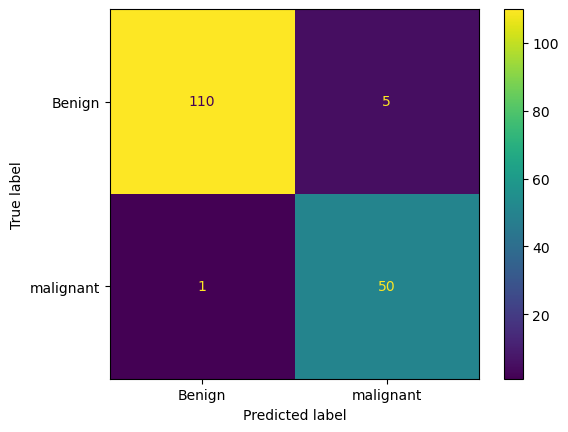

In [52]:
from sklearn import metrics
import matplotlib.pyplot as plt

df_prd = prd.select('label', 'prediction').toPandas()
cm = metrics.confusion_matrix(df_prd['label'], df_prd['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Benign','malignant'])
cm_display.plot()
plt.show()

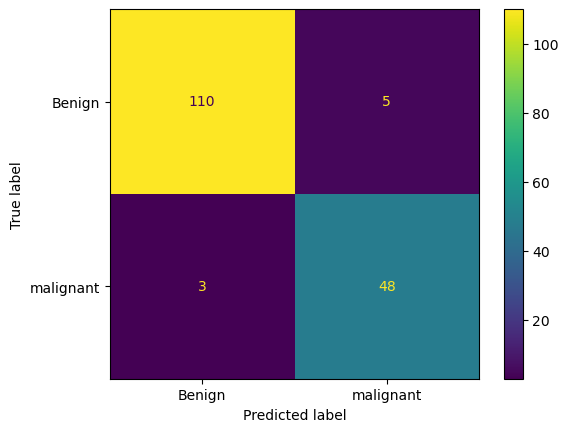

In [53]:
df_prd2 = prd2.select('label', 'prediction').toPandas()
cm = metrics.confusion_matrix(df_prd2['label'], df_prd2['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Benign','malignant'])
cm_display.plot()
plt.show()

In [54]:
spark.stop()